So, Titanic. Let me say, that this is both great and tricky problem for beginners to learn along the way. I am a beginner ML engineer, thus can verify it. I have more than 160 saves of this work, totally changed the code 3 times, starting with basic features choice to adding more features and ending up at reducing features. 

In this notebook I will show a bit of basic EDA with data visualizations, not going to deep into feature engineering (the main explanation of the whole process is below) and train the model with Random Forest Classifier. 
Let's dive into it!

**1. PassengerID**

Totally useless feature for modeling, it will be dropped by default.

**2. Survived**

That is our label, it will be used later for feature correlations. 

**3. Pclass**

Categorical feature, that can be used in a model with OneHotEncoder or without it. I am writing about RF only now. In the previous versions I used this feature with get_dummies, thus had three more features in the feature list. It demonstrates class of passengers' cabin. Very important one to understand  the difference of surviva rate. Well, that is too obvious. 

**4. Name**

In the first versions I used classical beginner approach - getting titles from names to understand which men could survive. It turned out that it was helpful, basically, I got another Sex features that gets weights of dying men. The result was 79,9% accuracy (mean the public score). The second way was adding Surnames. Feature list after get_dummies was too big (over 900 positions), but it didn't help at all, the result was not better than 78% accuracy. in the last version feature "Titles" was used as well.

**5. Sex**

Obvious as well. "Women and children first". i will provide some code to see that men had less chances to survive, of course.

**6. Age**

The way of processing this feature is the next one:
1) using mean values to fill mising values
2) using median (that really improved the score)
3) adding bins (another improvement of the score)
4) creating a function to fill missing values using Sex and Pclass, using median values of these groups
5) creating a function to fill missing values using Title feature and median. 

**7. SibSp and Parch**

The quantity of siblings, spouses, parents, children. Used it for creating features like FamilySize or IsAlone to get chances of survival depending on having a family or not. It happened that using all of them at once wasn't helpful, just a noise, no improvement to the model. I experimented with using only SibSp and  Parch, adding FamilySize or IsAlone to them, it didn't help. The answer was revealed later - if you have a lot of highly correlated features between themselves, it's better to use one-two of them. In this version there is Family_Size feature.

**8.Ticket and Fare**

Using this feature wasn't very helpful in terms of get_dummies. A lot of feature, some of them had some values in feature_importance table (because there were big families who used one ticket for all members of the family, it also included not only family members, but also nannys or servants etc). It had more helpful use in pair with **Fare** feature, because it was revealed that big families  in the third class have payed pretty big money that could be equal to second class prices. That is why I decided those were prices for the whole ticket and not a fare per person. Divided Fare/Ticket_Frequency and got Fare_per_one. 

**9. Cabin, Embarked**

Spent a lot of time on dealing with them - creating Decks, grouping those decks in different combinations, but it seems, the prefiction power of these features is not very high. 

About algorithms: used Random Forest, XGBoost, SVM, KNN. My personal favourite for this task is Random Forest, it did the best job, thus I lest only the code for using this particular algorithm. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
#Importing modules and libraries for data visualizations, algorithm, data splitting and testing, accuracy score
import seaborn as sns
import matplotlib as plt
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import LabelEncoder

In [3]:
train=pd.read_csv("/kaggle/input/titanic/train.csv")
test=pd.read_csv('/kaggle/input/titanic/test.csv')
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
#counting missing values of the train set
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
#counting missing values of the test set
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [6]:
#creating a function for data visualisations using seaborn
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64
mode:  0    0
dtype: int64
0    549
1    342
Name: Survived, dtype: int64


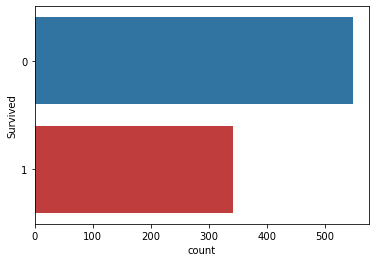

In [7]:
#cheking general numbers: how many passengers survived and died
#we can see that there are more passengers who died
c_palette = ['tab:blue', 'tab:red']
categorical_summarized(train, y = 'Survived', palette=c_palette)

count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object
mode:  0    male
dtype: object
male      577
female    314
Name: Sex, dtype: int64


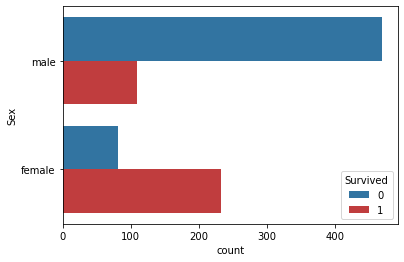

In [8]:
#the same thing, but using Sex - how many men and women survived. 
#Female survival chances were much higher than male ones.
categorical_summarized(train, y="Sex", hue = 'Survived', palette=c_palette)

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object
mode:  0    S
dtype: object
S    644
C    168
Q     77
Name: Embarked, dtype: int64


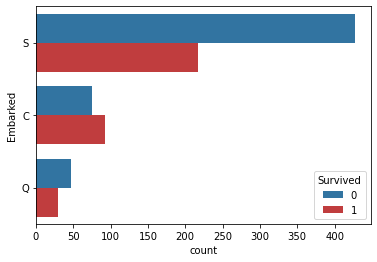

In [9]:
#distribution of dead/survived passengers depending on their embarkation
categorical_summarized(train, y= "Embarked", hue = 'Survived', palette=c_palette)

count    891.000000
mean       2.308642
std        0.836071
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: Pclass, dtype: float64
mode:  0    3
dtype: int64
3    491
1    216
2    184
Name: Pclass, dtype: int64


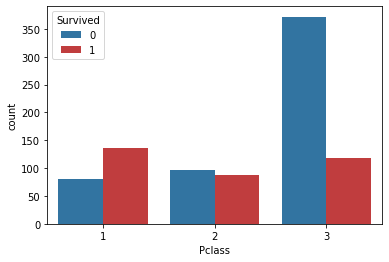

In [10]:
#The same numbers distributed by Pclass. Predictably, the higher class - the higher survival chances
categorical_summarized(train, x="Pclass", hue = 'Survived', palette=c_palette)

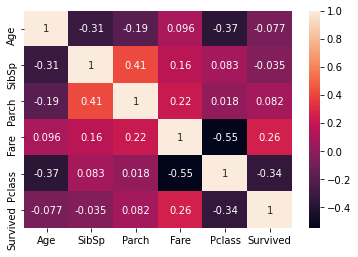

In [11]:
#Correlation map. We can see that the highest correlation with Survived label have Pclass and Fare
#those two features have pretty high correlation.
sns.heatmap((train.loc[:,["Age", "SibSp", 'Parch', 'Fare', 'Pclass', 'Survived']]).corr(), annot=True)

Violinplots to look at the distribution using Pclass and Age.
There were more dead people at the age 40-60 in the first class and more younger people survived (~25-45) and we can see some older outliers here. Very few kids survived and very few of them died, it seems, that there no many kids in the first class.
In the second class, there are much more dead people in younger category - 20-35 and a bit less of survived adults and kids (no kids till ~10 years old died)
In the third class, there are some kids who died, those ones whose families were too big. In general, the youngest people died in this group. My guess - young single men who were going for a better life and job.

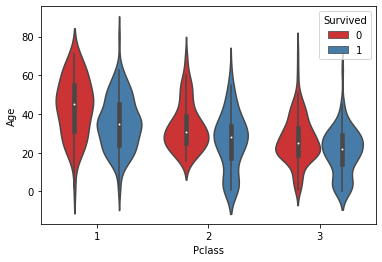

In [12]:

sns.violinplot(x="Pclass", y="Age", hue="Survived", data = train, palette = "Set1")

In [13]:
#concatenating data sets
all_data = train.append(test)

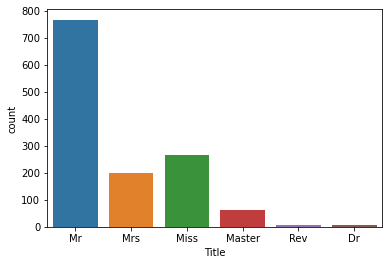

In [14]:
#Filling missing Age values, using created Title feature
import re
all_data['Title'] = all_data.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
all_data.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = all_data.groupby('Title')['Age'].median()[titles.index(title)]
    all_data.loc[(all_data['Age'].isnull()) & (all_data['Title'] == title), 'Age'] = age_to_impute
    
# Substituting Age values in train and test:
train['Age'] = all_data['Age'][:891]
test['Age'] = all_data['Age'][891:]

sns.countplot(x='Title', data=all_data);
#all_data.drop('Title', axis = 1, inplace = True)
train['Title'] = all_data['Title'][:891]
test['Title'] = all_data['Title'][891:]

train['Title'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Rev', 'Dr'],[1,2,3,4,5,6],inplace=True)
test['Title'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Rev', 'Dr'],[1,2,3,4,5,6],inplace=True)

In [15]:
all_data['Family_Size'] = all_data['Parch'] + all_data['SibSp']

# Substituting Age values in train and test data frames:
train['Family_Size'] = all_data['Family_Size'][:891]
test['Family_Size'] = all_data['Family_Size'][891:]

**Family_survival.**
This feature wasn't written by me. I googled the code having an idea what I need to do, thanks to SQL insights about grouping. The original work is here: https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever 
We will get family survival numbers: 0, 0.5, 1.

In [16]:
all_data['Last_Name'] = all_data['Name'].apply(lambda x: str.split(x, ",")[0])
all_data['Fare'].fillna(all_data['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
all_data['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in all_data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      all_data.loc[all_data['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 420


In [17]:
for _, grp_df in all_data.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(all_data[all_data['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in train and test:
train['Family_Survival'] = all_data['Family_Survival'][:891]
test['Family_Survival'] = all_data['Family_Survival'][891:]

Number of passenger with family/group survival information: 546


In [18]:
#counting for how many people every ticket was usedm another grouping
all_data['Ticket_Frequency'] = all_data.groupby('Ticket')['Ticket'].transform('count')
train['Ticket_Frequency'] = all_data['Ticket_Frequency'][:891]
test['Ticket_Frequency'] = all_data['Ticket_Frequency'][891:]

In [19]:
#Fare per one
all_data["Fare"] = all_data["Fare"].fillna(test["Fare"].median())
all_data["Fare_per_one"]=all_data['Fare']/all_data['Ticket_Frequency']

# Making 16 Bins for Fare
all_data['FareBin'] = pd.qcut(all_data['Fare_per_one'], 16)

label = LabelEncoder()
all_data['FareBin_Code'] = label.fit_transform(all_data['FareBin'])

train['FareBin_Code'] = all_data['FareBin_Code'][:891]
test['FareBin_Code'] = all_data['FareBin_Code'][891:]

train.drop(['Fare'], 1, inplace=True)
test.drop(['Fare'], 1, inplace=True)

In [20]:
#Making 4 bins for Age
all_data['AgeBin'] = pd.qcut(all_data['Age'], 6)

label = LabelEncoder()
all_data['AgeBin_Code'] = label.fit_transform(all_data['AgeBin'])

train['AgeBin_Code'] = all_data['AgeBin_Code'][:891]
test['AgeBin_Code'] = all_data['AgeBin_Code'][891:]

train.drop(['Age'], 1, inplace=True)
test.drop(['Age'], 1, inplace=True)

Let's have a look at new correlation map. 
As was said, SibSp, Parch, Family Size are highly correlated. It could be expected 1.0 correlation between Family_size and Ticket_Frequency, but it is only 0.82

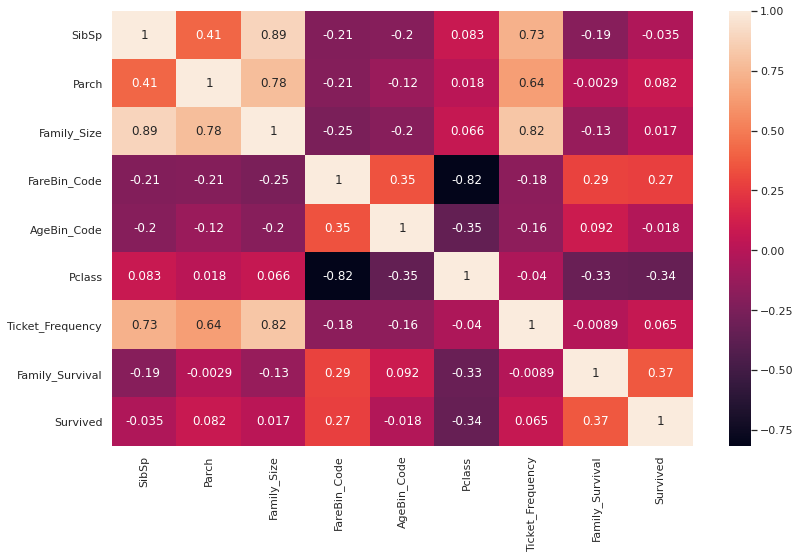

In [21]:
sns.set(rc={'figure.figsize':(13,8)})
sns.heatmap((train.loc[:,['SibSp', 'Parch', 'Family_Size','FareBin_Code', 
            'AgeBin_Code','Pclass', 'Ticket_Frequency', 'Family_Survival','Survived']]).corr(), annot=True)

In [22]:
#replacing 'malee' and 'female' with 0 and 1 for the algoritm
train['Sex'].replace(['male','female'],[0,1],inplace=True)
test['Sex'].replace(['male','female'],[0,1],inplace=True)

#dropping unnecessary features
train.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin', 
               'Embarked'], axis = 1, inplace = True)
test.drop(['Name','PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin', 
              'Embarked'], axis = 1, inplace = True)

In [23]:
train.head()

,Survived,Pclass,Sex,Title,Family_Size,Family_Survival,Ticket_Frequency,FareBin_Code,AgeBin_Code
0,0,3,0,1,1,0.5,1,3,1
1,1,1,1,2,1,0.5,2,14,4
2,1,3,1,3,0,0.5,1,6,2
3,1,1,1,2,1,0.0,2,12,4
4,0,3,0,1,0,0.5,1,7,4


In [24]:
y = train['Survived']
train_df = train.drop('Survived', 1)
test_df = test.copy()

In [25]:
#test/train splitting
my_train, my_test, my_y, my_res = train_test_split(train_df, y, test_size=0.1, random_state=42)

In [26]:
#creating trial RFC model
model_try = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=42)
model_try.fit(my_train, my_y)
preds = model_try.predict(my_test)
print(accuracy_score(my_res, preds))

0.8777777777777778


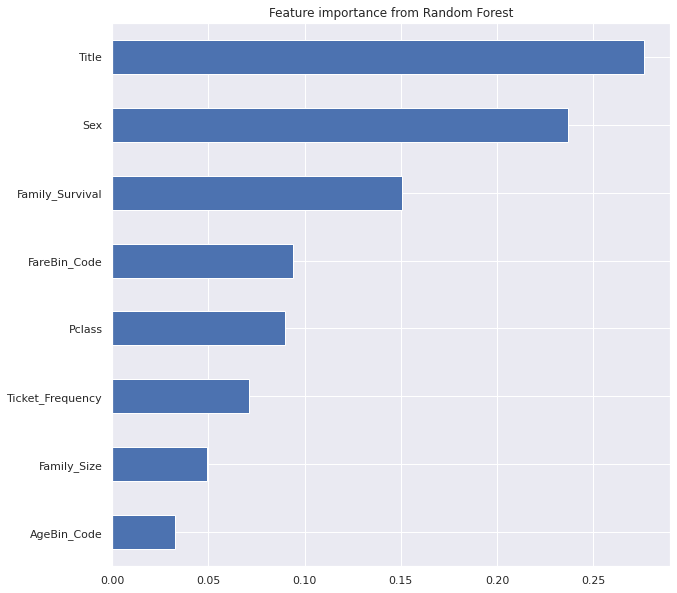

In [27]:
#feature importance of the algorithm
pd.Series(model_try.feature_importances_, index = my_train.columns).nlargest(12).plot(kind = 'barh',
                            figsize = (10, 10),title = 'Feature importance from Random Forest').invert_yaxis()

In [28]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [29]:
#creating the model, predictions and output
model = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=42)
model.fit(train_df, y)
predictions = model.predict(test_df)
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print(predictions)

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 1]


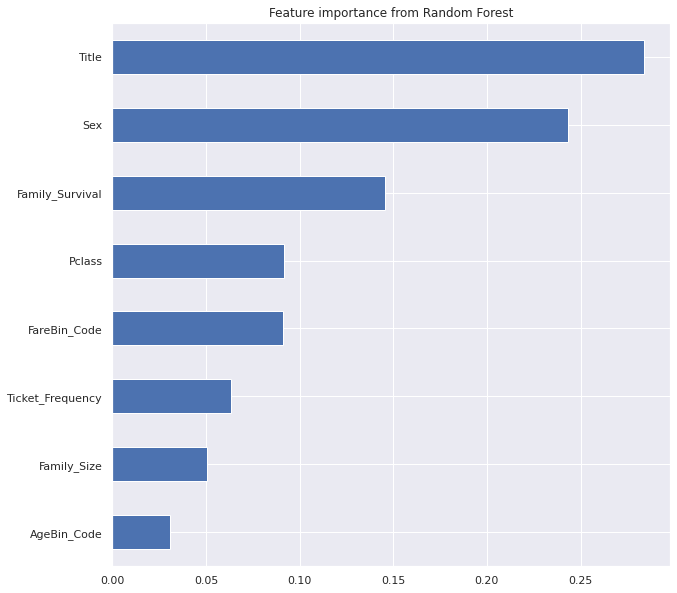

In [30]:
#feature importance iss a bit different from the above model on train data
pd.Series(model.feature_importances_, index = train_df.columns).nlargest(30).plot(kind = 'barh',
                            figsize = (10, 10),title = 'Feature importance from Random Forest').invert_yaxis()